<a href="https://colab.research.google.com/github/Abmiester/BERT_sentiment/blob/master/BERT_fine_tuning_sentence_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# BERT fine-tuning sentence classification
We will be applying pre-trained BERT moder to the CoLA sentence classificatin benchmark. We will also be testing out the freely available Tesla GPU available to us.

In [1]:
!pip install transformers
!pip install wget

     |████████████████████████████████| 675kB 10.6MB/s 
     |████████████████████████████████| 890kB 16.3MB/s 
     |████████████████████████████████| 3.8MB 47.0MB/s 
     |████████████████████████████████| 1.1MB 50.7MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp36-none-any.whl size=893260 sha256=47cc301b4a5aab2dd1cf5417e35c39ed7b57d2dc8e08b84d40a8db08fe1e3ba2
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
  Created wheel for wget: filename=wget-3.2-cp36-none-any.whl size=9682 sha256=027b8b0b4a83a83182eb65bacd643248663b15747bae75e5687b700c4cbd893e
  Stored in directory: /root/.cache/pip/wheels/40/15/30/7d8f7cea2902b4db79e3fea550d7d7b85ecb27ef992b618f3f
Successfully built wget


In [0]:
import pandas as pd
import tensorflow as tf
import torch
import transformers
import wget
import os
import numpy as np
import time
import datetime
import random
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import BertTokenizer
from torch.utils.data import TensorDataset, random_split
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
from transformers import BertForSequenceClassification, AdamW, BertConfig, get_linear_schedule_with_warmup
from sklearn.metrics import matthews_corrcoef

In [3]:
# get GPU device name
device_name = tf.test.gpu_device_name()

# the device name
if device_name == '/device:GPU:0':
  print('Found GPU at: {}'.format(device_name))
else:
  raise SystemError('GPU not found.')

Found GPU at: /device:GPU:0


In [4]:
# if GPU is available
if torch.cuda.is_available():
  device = torch.device('cuda')
  print('There are {} GPU(s) available.'.format(torch.cuda.device_count()))
  print('We will use the GPU: {}'.format(torch.cuda.get_device_name(0)))
else:
  print('No GPU available, using CPU instead.')
  device = torch.device('cpu')

There are 1 GPU(s) available.
We will use the GPU: Tesla P4


For this, we will use the modification of the BERT model; `BertForSequenceClassification`.

## Loading Corpus of Linguistic Acceptability (CoLA)

In [0]:
# URL for dataset zip file
url = 'https://nyu-mll.github.io/CoLA/cola_public_1.1.zip'

# download
if not os.path.exists('./cola_public_1.1.zip'):
  wget.download(url, './cola_public_1.1.zip')

In [6]:
# unzip dataset
if not os.path.exists('./cola_public/'):
  !unzip cola_public_1.1.zip

Archive:  cola_public_1.1.zip
   creating: cola_public/
  inflating: cola_public/README      
   creating: cola_public/tokenized/
  inflating: cola_public/tokenized/in_domain_dev.tsv  
  inflating: cola_public/tokenized/in_domain_train.tsv  
  inflating: cola_public/tokenized/out_of_domain_dev.tsv  
   creating: cola_public/raw/
  inflating: cola_public/raw/in_domain_dev.tsv  
  inflating: cola_public/raw/in_domain_train.tsv  
  inflating: cola_public/raw/out_of_domain_dev.tsv  


In [7]:
# load dataset into a dataframe
df = pd.read_csv(
    './cola_public/raw/in_domain_train.tsv',
    delimiter='\t',
    header=None,
    names=['sentence_source', 'label', 'label_notes', 'sentence']
    )

# report number of sentences
print('Number of sentences: {}'.format(df.shape[0]))

# display ten random rows
df.sample(10)

Number of sentences: 8551


,sentence_source,label,label_notes,sentence
7875,ad03,1,NaN,Close the door!
4714,ks08,1,NaN,Their expectations will be kept up with.
8326,ad03,1,NaN,Perhaps Iphigenia will have murdered Oedipus b...
595,bc01,1,NaN,The tree dropped some branches.
3438,ks08,1,NaN,The man kicked the ball.
3026,l-93,1,NaN,We rummaged in the drawer for important docume...
900,bc01,1,NaN,I visited every town I had to.
4387,ks08,0,*,The house is been remodelling.
7554,sks13,0,*,I heard John's criticism of myself.
2039,rhl07,1,NaN,I sent the package to the Antarctic.


In [0]:
# get lists of sentences and their labels
sentences = df.sentence.values
labels = df.label.values

## Tokenization and input formatting

In [9]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

In [10]:
# print one of the sentences, one of the sentence split into tokens, and and one of the token ids
print('Original: {}'.format(sentences[0]))
print('Tokenized: {}'.format(tokenizer.tokenize(sentences[0])))
print('Token IDs: {}'.format(tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0]))))

Original: Our friends won't buy this analysis, let alone the next one we propose.
Tokenized: ['our', 'friends', 'won', "'", 't', 'buy', 'this', 'analysis', ',', 'let', 'alone', 'the', 'next', 'one', 'we', 'propose', '.']
Token IDs: [2256, 2814, 2180, 1005, 1056, 4965, 2023, 4106, 1010, 2292, 2894, 1996, 2279, 2028, 2057, 16599, 1012]


## Tokenize dataset

In [11]:
input_ids = []
attention_masks = []

for sent in sentences:
  encoded_dict = tokenizer.encode_plus(
      sent,
      add_special_tokens=True,
      max_length = 64,
      pad_to_max_length = True,
      return_attention_mask = True,
      return_tensors = 'pt'
      )
  
  input_ids.append(encoded_dict['input_ids'])
  attention_masks.append(encoded_dict['attention_mask'])

# convert lists into tensors
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# print one of the tensors
print('Original: {}'.format(sentences[0]))
print('Token IDs: {}'.format(input_ids[0]))

Original: Our friends won't buy this analysis, let alone the next one we propose.
Token IDs: tensor([  101,  2256,  2814,  2180,  1005,  1056,  4965,  2023,  4106,  1010,
         2292,  2894,  1996,  2279,  2028,  2057, 16599,  1012,   102,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


In [12]:
# combining training inputs into a TensorDataset
dataset = TensorDataset(input_ids, attention_masks, labels)

# create a 90-10 train-validation split
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

# divide dataset by randomly selecting samples
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{} training samples'.format(train_size))
print('{} validation samples'.format(val_size))

7695 training samples
856 validation samples


We'll create an iterator for our dataset using DataLoader. This way, we can save on memory during training.

In [0]:
batch_size = 32

# create training and validation DataLoaders
train_dataloader = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    batch_size=batch_size
    )

validation_dataloader = DataLoader(
    val_dataset,
    sampler=SequentialSampler(val_dataset),
    batch_size=batch_size
    )

## Train classification model
We'll be using `BertForSequenceClassification`. This is the normal BERT model with an added single linear layer on top for classification that we will use as a sentence classifier. As we feed input data, the entire pre-trained BERT model and the additional untrained classification layer is trained to our specific task.

In [14]:
model = BertForSequenceClassification.from_pretrained(
    'bert-base-uncased',
    num_labels = 2,
    output_attentions = False,
    output_hidden_states = False
)

model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

To sake curiosity, print names and dimensions of the weights for:
- Embedding layer
- Firsr of the twelve transformers
- Output layer

In [16]:
params = list(model.named_parameters())

print('The BERT model has {} different named parameters.'.format(len(params)))

print('-----Embedding layer-----')
for p in params[0:5]:
  print('{}: {}'.format(p[0], tuple(p[1].size())))

print('-----First transformer-----')
for p in params[5:21]:
  print('{}: {}'.format(p[0], tuple(p[1].size())))

print('-----Output layer-----')
for p in params[-4:]:
  print('{}: {}'.format(p[0], p[0], tuple(p[1].size())))

The BERT model has 201 different named parameters.
-----Embedding layer-----
bert.embeddings.word_embeddings.weight: (30522, 768)
bert.embeddings.position_embeddings.weight: (512, 768)
bert.embeddings.token_type_embeddings.weight: (2, 768)
bert.embeddings.LayerNorm.weight: (768,)
bert.embeddings.LayerNorm.bias: (768,)
-----First transformer-----
bert.encoder.layer.0.attention.self.query.weight: (768, 768)
bert.encoder.layer.0.attention.self.query.bias: (768,)
bert.encoder.layer.0.attention.self.key.weight: (768, 768)
bert.encoder.layer.0.attention.self.key.bias: (768,)
bert.encoder.layer.0.attention.self.value.weight: (768, 768)
bert.encoder.layer.0.attention.self.value.bias: (768,)
bert.encoder.layer.0.attention.output.dense.weight: (768, 768)
bert.encoder.layer.0.attention.output.dense.bias: (768,)
bert.encoder.layer.0.attention.output.LayerNorm.weight: (768,)
bert.encoder.layer.0.attention.output.LayerNorm.bias: (768,)
bert.encoder.layer.0.intermediate.dense.weight: (3072, 768)
bert

## Optimizer and learning rate scheduler
We choose:
- Batch size: 32
- Learning rate: 2e-5
- Epochs: 4
- Epsilon parameter: 1e-8 (very small number to prevent any division by zero in implementation)

In [0]:
# AdamW optimizer (W stands for Weight Decay Fix)
optimizer = AdamW(
    model.parameters(),
    lr=2e-5,
    eps=1e-8
)

In [0]:
epochs = 4

# total number of training steps is number of batches x number of epochs
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

## Training
For each loop, there's a training phase and a validation phase.

1. Training:
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Clear out the gradients calculated in the previous pass. In PyTorch the gradients accumulate by default (useful for things like RNNs) unless you explicitly clear them out.
-  Forward pass (feed input data through the network)
- Backward pass (backpropagation)
- Tell the network to update parameters with optimizer.step()
- Track variables for monitoring progress

2. Evalution:
- Unpack our data inputs and labels
- Load data onto the GPU for acceleration
- Forward pass (feed input data through the network)
- Compute loss on our validation data and track variables for monitoring progress

In [0]:
def flat_accuracy(preds, labels):
  '''
  takes predictions and labels
  returns calculated accuracy of predictions vs. labels
  '''
  pred_flat = np.argmax(preds, axis=1).flatten()
  labels_flat = labels.flatten()
  return np.sum(pred_flat == labels_flat)/len(labels_flat)


def format_time(elapsed):
  '''
  takes time in seconds
  returns string in hh:mm:ss format
  '''
  elapsed_rounded = int(round(elapsed))
  return str(datetime.timedelta(seconds=elapsed_rounded))

In [0]:
# set seed value to make reproducible
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

In [45]:
training_stats = []

# measure the total training time for the whole run
total_t0 = time.time()

for epoch_i in range(0, epochs):
    # perform one full pass over the training set
    print('----- Epoch {} / {} -----'.format(epoch_i + 1, epochs))

    t0 = time.time()
    # reset the total loss for this epoch
    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):
        if step % 40 == 0 and not step == 0:
            # calculate elapsed time in minutes
            elapsed = format_time(time.time() - t0)
            print('Batch {} of {}. Elapsed: {}.'.format(step, len(train_dataloader), elapsed))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # clear previously calculated gradients before performing a backward pass
        model.zero_grad()        

        # perform a forward pass; returns loss (because we provided labels) and logits which the model outputs prior to activation
        loss, logits = model(b_input_ids, 
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels
                             )

        # accumulate the training loss over all of the batches
        total_train_loss += loss.item()

        loss.backward()

        # clip the norm of the gradients to 1.0, prevents the exploding gradients problem
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    # measure how long the epoch took
    training_time = format_time(time.time() - t0)

    print('Average training loss: {}'.format(avg_train_loss))
    print('Training epoch took: {}'.format(training_time))
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    # Tracking variables 
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        
        with torch.no_grad():        
            loss, logits = model(b_input_ids,
                                 token_type_ids=None,
                                 attention_mask=b_input_mask,
                                 labels=b_labels
                                 )
            
        # accumulate the validation loss
        total_eval_loss += loss.item()

        # move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # calculate the accuracy for this batch of test sentences
        total_eval_accuracy += flat_accuracy(logits, label_ids)
        

    # final accuracy for this validation run
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("Accuracy: {}".format(avg_val_accuracy))

    # calculate the average loss over all of the batches
    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0)
    
    print('Validation Loss: {}'.format(avg_val_loss))
    print('Validation time: {}'.format(validation_time))

    # record all statistics from this epoch.
    training_stats.append(
        {
            'Epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("Total training took {} (h:mm:ss)".format(format_time(time.time()-total_t0)))

----- Epoch 1 / 4 -----
Batch 40 of 241. Elapsed: 0:00:17.
Batch 80 of 241. Elapsed: 0:00:34.
Batch 120 of 241. Elapsed: 0:00:51.
Batch 160 of 241. Elapsed: 0:01:08.
Batch 200 of 241. Elapsed: 0:01:25.
Batch 240 of 241. Elapsed: 0:01:42.
Average training loss: 0.4629319050500007
Training epoch took: 0:01:42
Running Validation...
Accuracy: 0.8097993827160493
Validation Loss: 0.45216561136422334
Validation time: 0:00:03
----- Epoch 2 / 4 -----
Batch 40 of 241. Elapsed: 0:00:17.
Batch 80 of 241. Elapsed: 0:00:34.
Batch 120 of 241. Elapsed: 0:00:51.
Batch 160 of 241. Elapsed: 0:01:08.
Batch 200 of 241. Elapsed: 0:01:25.
Batch 240 of 241. Elapsed: 0:01:42.
Average training loss: 0.27829316811813853
Training epoch took: 0:01:43
Running Validation...
Accuracy: 0.8283179012345678
Validation Loss: 0.46607031921545666
Validation time: 0:00:03
----- Epoch 3 / 4 -----
Batch 40 of 241. Elapsed: 0:00:17.
Batch 80 of 241. Elapsed: 0:00:34.
Batch 120 of 241. Elapsed: 0:00:51.
Batch 160 of 241. Elapsed

In [46]:
pd.set_option('precision', 2)
df_stats = pd.DataFrame(data=training_stats)
df_stats.set_index('Epoch', inplace=True)
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
Epoch,,,,,
1,0.46,0.45,0.81,0:01:42,0:00:03
2,0.28,0.47,0.83,0:01:43,0:00:03
3,0.19,0.54,0.83,0:01:43,0:00:03
4,0.12,0.64,0.83,0:01:43,0:00:03


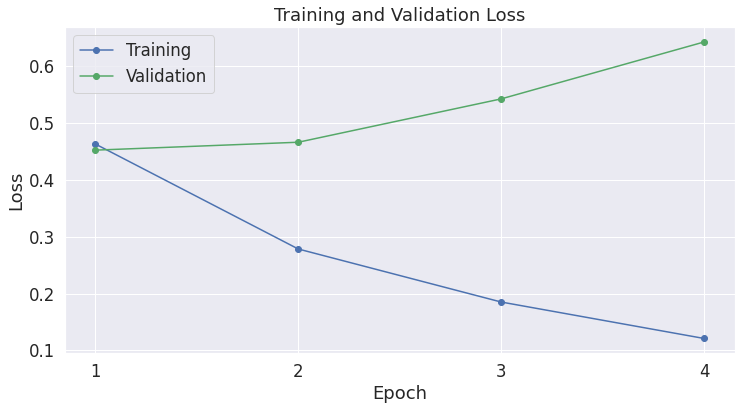

In [48]:
sns.set(style='darkgrid')
sns.set(font_scale=1.5)

plt.rcParams['figure.figsize'] = (12, 6)

plt.plot(df_stats['Training Loss'], 'b-o', label='Training')
plt.plot(df_stats['Valid. Loss'], 'g-o', label='Validation')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.xticks([1, 2, 3, 4])
plt.show()

## Performance on test set
We'll load the holdout dataset, and prepare inputs just like we did with the training set. We'll evaluate predictions using Matthew's correlation coefficient; +1 is the best score, -1 is the worst score.

### Data Preparation

In [49]:
df = pd.read_csv(
    "./cola_public/raw/out_of_domain_dev.tsv",
    delimiter='\t',
    header=None,
    names=['sentence_source', 'label', 'label_notes', 'sentence']
    )

print('Number of test sentences: {}'.format(df.shape[0]))

sentences = df.sentence.values
labels = df.label.values

input_ids = []
attention_masks = []

for sent in sentences:
    encoded_dict = tokenizer.encode_plus(
                        sent,
                        add_special_tokens = True,
                        max_length = 64,
                        pad_to_max_length = True,
                        return_attention_mask = True,
                        return_tensors = 'pt'
                   )
     
    input_ids.append(encoded_dict['input_ids'])
    attention_masks.append(encoded_dict['attention_mask'])

input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)
 
batch_size = 32  

prediction_data = TensorDataset(input_ids, attention_masks, labels)
prediction_sampler = SequentialSampler(prediction_data)
prediction_dataloader = DataLoader(prediction_data, sampler=prediction_sampler, batch_size=batch_size)

Number of test sentences: 516


### Evaluate on test set
We can apply our fine tuned model to generate predictions on the test set.

In [50]:
print('Predicting labels for {} test sentences.'.format(len(input_ids)))

model.eval()

predictions, true_labels = [], []

for batch in prediction_dataloader:
  # add batch to gpu
  batch = tuple(t.to(device) for t in batch)

  b_input_ids, b_input_mask, b_labels = batch

  # preventing the model from computing and storing gradients, saving memory and speeding up prediction
  with torch.no_grad():
    outputs = model(
        b_input_ids,
        token_type_ids=None,
        attention_mask=b_input_mask
    )
  logits = outputs[0]

  # move results to cpu
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  predictions.append(logits)
  true_labels.append(label_ids)

Predicting labels for 516 test sentences.


In [51]:
# checking class balance
print('Positive samples: {} of {} which is {}%'.format(df.label.sum(), len(df.label), round((df.label.sum()/len(df.label))*100, 2)))

Positive samples: 354 of 516 which is 68.6%


In [52]:
matthews_set = []

for i in range(len(true_labels)):
  pred_labels_i = np.argmax(predictions[i], axis=1).flatten()
  matthews = matthews_corrcoef(true_labels[i], pred_labels_i)
  matthews_set.append(matthews)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:900: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


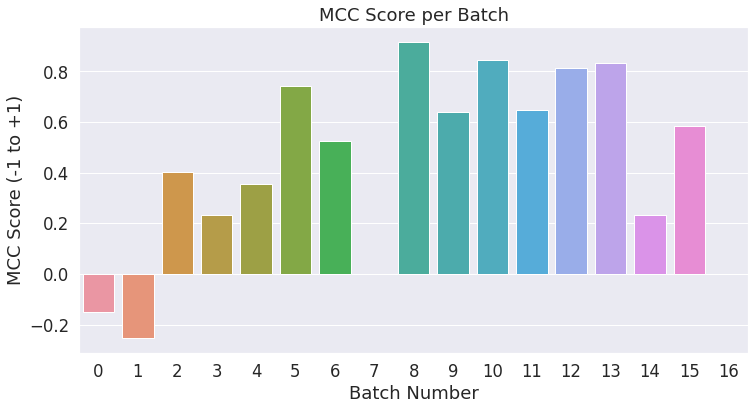

In [53]:
ax = sns.barplot(x=list(range(len(matthews_set))), y=matthews_set, ci=None)
plt.title('MCC Score per Batch')
plt.ylabel('MCC Score (-1 to +1)')
plt.xlabel('Batch Number')
plt.show()

In [54]:
flat_predictions = np.concatenate(predictions, axis=0)
flat_predictions = np.argmax(flat_predictions, axis=1).flatten()
flat_true_labels = np.concatenate(true_labels, axis=0)
mcc = matthews_corrcoef(flat_true_labels, flat_predictions)
print('Total MCC: {}'.format(mcc))

Total MCC: 0.5136912990448256


The result is good, but we can improve on this result with hyperparameter tuning like adjusting the learning rate, epochs, batch size, ADAM properties etc.